In [1]:
import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils.plots import custom_color_code, save_vector_image
from sklearn.metrics import f1_score

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
df = pd.read_csv('C:/WORKSPACE_KRICT/DATA/material/data_snu/with_metal/id_target.csv')
map_id_gga_is_metal = {int(id):gga == 0 for i, (id, gga, _, _, _, _, _) in df.iterrows()}

cmap_list = ['Reds','Greens','Purples','Blues','Greys']
#intervals = [ (1e-2, 0.2), (0.2, 0.4), (0.4, 0.6), (0.6, 0.9), (0.9, 1.5), (1.5, np.inf)]
intervals = [ (1e-2, 0.5), (0.5,1), (1, np.inf)]

In [4]:
def MAE(y_true, y_pred):
    if len(y_true) == 0: return 0
    abs_diff = np.abs(np.array(y_true) - np.array(y_pred))
    return np.mean(abs_diff)

def MSE(y_true, y_pred):
    if len(y_true) == 0: return 0
    abs_diff = np.abs(np.array(y_true) - np.array(y_pred))
    return np.mean(np.square(abs_diff))
    
def calc_loss(fn, target, pred, v1=None, v2=None, ratio=False):
    mask = np.ones((target.shape[0]), dtype=bool)
    if v1: mask = mask & (target >= v1)
    if v2: mask = mask & (target < v2)
    loss = fn(target[mask], pred[mask])
    if not ratio:
        return loss
    else:
        return loss, 100*np.sum(mask)/mask.shape[0]

def graph_name(v1, v2):
    return 'MAE: {:.2f}-{:.2f} eV'.format(v1, v2)

def get_prediction(model_type, idxs=[-4], subidx=-2):
    global root_models
    path = os.path.join(root_models, model_type)
    if not os.path.isdir(path):
        raise ValueError(f'invalid model type - model_type={model_type}', root_models, os.listdir(root_models))
    data = dict()
    for model_name in os.listdir(path):
        model_path = os.path.join(path, model_name)
        preds = {}
        for fn in os.listdir(model_path):
#            if fn.startswith('test.0') and fn.endswith('.csv'):
            if fn.startswith('prb_gw') and fn.endswith('.csv'):
#            if fn.startswith('prb_mbj') and fn.endswith('.csv'):
                df = pd.read_csv(os.path.join(model_path, fn))
                preds[int(fn.split('.')[-2])] = np.array(df).T
#            if fn.startswith('pred') and fn.endswith('.txt'):
#                preds[int(fn.split('.')[1])] = np.loadtxt(os.path.join(model_path, fn), delimiter=',').T
        key = os.path.join(model_type, model_name).replace('\\','/').replace('\\','')
        data[key] = [(epoch, pred) for epoch, pred in sorted(preds.items(), key=lambda x: x[0])]
    ccc = custom_color_code(data.keys(), idxs=idxs, subidx=subidx)
    return {k:data[k] for k in ccc.map_order.keys()}

def plot_graph(data, ncol=2, gmax=10.5, highlight_gga=False, bfs=(6,5), with_title=True, with_acc=False, acc_mul=0.05, with_metal=False):
    global intervals
    gmin = int(gmax) - gmax
    nrow = int(len(data)/ncol)
    if len(data)%ncol != 0: nrow += 1
    f, axs = plt.subplots(nrow, ncol, figsize=(bfs[0]*ncol, bfs[1]*nrow))
    axs = axs.reshape(-1)

    for i, (model_name, (id, target, pred)) in enumerate(data.items()):
        if with_title: axs[i].set_title(model_name, fontsize=20)
        axs[i].tick_params(axis='both', labelsize=15)

        ax_gap = axs[i]
        ax_gap.plot([0,20],[0,20],'-k')
        metal = target < 1e-2
        if not highlight_gga:
            if with_metal:
                ax_gap.scatter(target[metal], pred[metal], alpha=0.3, marker='D', linewidths=1, color=[0,0.1,1])
            ax_gap.scatter(target[~metal], pred[~metal], alpha=0.3, marker='o', linewidths=1, color=[1,0.1,0.5])
        else:
            mask_gga = np.array([map_id_gga_is_metal[int(icsd)] in map_id_gga_is_metal for icsd in id])
            if with_metal:
                ax_gap.scatter(target[metal], pred[metal], marker='D',alpha=0.4, linewidths=1, color=[0,0.1,1])
            ax_gap.scatter(target[~mask_gga & ~metal], pred[~mask_gga & ~metal], marker='o',alpha=0.4, linewidths=1, color=[1,0.1,0.5])
            ax_gap.scatter(target[mask_gga & ~metal], pred[mask_gga & ~metal], marker='D', alpha=0.4, linewidths=1, color=[0,1,0.5])
        ax_gap.set_xlim([gmin, gmax])
        ax_gap.set_ylim([gmin, gmax])
        ax_gap.axvline(0, ls='--', color=[0,0,0], linewidth=0.5)
        ax_gap.axhline(0, ls='--', color=[0,0,0], linewidth=0.5)
        ax_gap.set_xlabel('PRB270 G0W0 band gap (eV)', fontsize=17)
        ax_gap.set_ylabel('Predicted band gap (eV)', fontsize=17)

        if with_acc:
            ax_acc = axs[i].twinx()
            amax = acc_mul*(gmax)/(-gmin)
            ax_acc.set_ylim([-acc_mul,amax])
            ax_acc.set_ylabel('MAE (eV)', fontsize=17)
            ax_acc.tick_params(axis='y', labelsize=15)
            for _, (v1, v2) in enumerate(intervals):
                if v1 > gmax: continue
                ax_gap.axvline(v2, ls='--', color=[0,0,0], linewidth=0.5)
                l = calc_loss(fn=MAE, target=target, pred=pred, v1=v1, v2=v2)
                txt = '{:.1f}~{:.1f}\n{:.3f} eV'.format(v1, v2, l)
                if v2 == np.inf: v2 = gmax
                ax_acc.hlines(l, v1, v2, color=[0,0,1], linewidth=2)
                if v2 - v1 < gmax/10:
                    ax_acc.text((v1 + v2)*0.5 - gmax/50, l + amax/40, txt, rotation=90)
                else:
                    ax_acc.text((v1 + v2)*0.5 - gmax/20, l + amax/50, txt)

        label  = 'MAE, All data   : {:.3f}'.format(MAE(target, pred))
        if with_metal or highlight_gga:
            label += '\nMAE, Insulator  : {:.3f}'.format(calc_loss(MAE, target, pred, 1e-2, None))
            pred_mask = pred < 1e-2
            target_mask = target < 1e-2
            if np.sum(target_mask) == 0: 
                f1 = 0
            else:
                f1 = f1_score(target_mask, pred_mask, average='micro')
            label += '\nF1, Metal Clas. : {:.3f}'.format(f1)
        box = dict(boxstyle='round', facecolor='wheat', alpha=1)
        ax_gap.text(gmax - gmax*0.03, gmin + gmax*0.03, label, fontsize=14, ha='right', va='bottom', bbox=box)
    plt.tight_layout()
    return f

def plot_acc_bar(pred_data, x, axs, color=None, width=0.7, value=False, ylim=[0,0.5]):
    global intervals
    _, target, pred = pred_data
    loss_all = calc_loss(MAE, target, pred)
    loss_ins, r_ins = calc_loss(MAE, target, pred, v1=1e-2, ratio=True)
    pred_mask = pred < 1e-2
    target_mask = target < 1e-2

    f1_met, r_metal = (f1_score(target_mask, pred_mask, average='micro'), 100*np.sum(target_mask)/target.shape[0]) if np.sum(target_mask) != 0 else (0, 0)

    for i, (title, l, label) in enumerate(
            [['All data', loss_all, '{:.3f}'.format(loss_all)],
             ['HSE Insulator', loss_ins, '{:.3f}\n({:.0f}%)'.format(loss_ins, r_ins)],
             ['HSE Metal', f1_met, '{:.3f}\n({:.0f}%)'.format(f1_met, r_metal)]]):
        p = axs[i].bar(x, l, width, color=color)
        if value:
            axs[i].bar_label(p, labels=[label], rotation=90, padding=3)
        axs[i].set_title(title)
        if 'Metal' not in title:
            axs[i].set_ylim(ylim)
        else:
            axs[i].set_ylim(0,1.2)
    
    for i, v in enumerate(intervals):
        l, r = calc_loss(MAE, target=target, pred=pred, v1=v[0], v2=v[1], ratio=True)
        p = axs[i+3].bar(x, l, width, color=color, label=label)
        if value:
            axs[i+3].bar_label(p, labels=['{:.3f}\n({:.0f}%)'.format(l, r)], 
                            rotation=90, padding=3)
        axs[i+3].set_title(graph_name(*v))
        axs[i+3].set_ylim(ylim)

def plot_acc_line(pred_data, axs, color=None, label=''):
    global intervals
    for i, (title, v1, v2) in enumerate(
            [['All data',0,np.inf],
             ['Insulator',1e-2,np.inf],
             ['Metal',0,1e-2]]):
        output = []       
        for epoch, (_, target, pred) in pred_data:
            mask = (target >= v1) & (target < v2)
            l1 = MAE(target[mask], pred[mask])#, ratio=True)
            output.append([epoch, l1])
        epochs, accs = np.array(output).T
        axs[i].plot(epochs, accs, color=color, label=label)
        axs[i].set_title(title)
        
    for i, v in enumerate(intervals):
        output = []
        for epoch, (_, target, pred) in pred_data:
            l = calc_loss(MAE, target, pred, v[0], v[1])
            output.append([epoch, l])
        epochs, accs = np.array(output).T
        axs[i+3].plot(epochs, accs, color=color, label=label)
        axs[i+3].set_title(graph_name(*v))

def plot_data_by_model(model_types, model_names=['*'], order=-1, idxs=[-4], subidx=-2, **kwargs):
    if type(model_types) != type(list()): model_types = [model_types]
    if type(model_names) != type(list()): model_names = [model_names]
    data = {}
    for model_type in model_types:
        preds = get_prediction(model_type=model_type, idxs=idxs, subidx=subidx)
        for model_name_pred, pred in preds.items():
            if order >= len(pred) or len(pred) == 0: 
                continue
            for model_name in model_names:
                if model_name == '*' or model_name in model_name_pred:
                    epoch, pred_data = pred[order]
                    data[model_name_pred+f'_epoch:{epoch}'] = pred_data
    return plot_graph(data, **kwargs)

def plot_data_of_model(model_type, model_name, idxs=[-4], subidx=-2):
    data = {}
    preds = get_prediction(model_type=model_type, idxs=idxs, subidx=subidx)
    for model_name_pred, pred in preds.items():
        if model_name in model_name_pred:
            for epoch, pred_data in pred.items():
                data[model_name_pred + f'_epoch:{epoch}'] = pred_data
    return plot_graph(data)

def plot_acc_by_model(model_types, model_names=['*'], order=-1, value=True, figsize=(12, 10), 
                      idxs=[-4], subidx=-2, ylim=None, hbars=None):
    if type(model_types) != type(list()): model_types = [model_types]
    if type(model_names) != type(list()): model_names = [model_names]
    global intervals
    f, axs = plt.subplots(len(intervals)+3, 1, figsize=figsize)
    data = {}
    colors = []
    for i, model_type in enumerate(model_types):
        preds = get_prediction(model_type=model_type, idxs=idxs, subidx=subidx)
        model_key = []
        for model_name_pred, pred in preds.items():
            if order >= len(pred) or len(pred) == 0: 
                continue
            for model_name in model_names:
                if model_name == '*' or model_name in model_name_pred:
                    epoch, output = pred[order]
                    model_key.append(model_name_pred)
                    data[model_name_pred + f'_epoch:{epoch}'] = output
        if len(model_key) == 0: continue
        colors.append(custom_color_code(model_key, idxs=idxs, subidx=subidx).get_rgba(cmap_list[i%len(cmap_list)]))
    
    if len(colors) == 0:
        print('no data')
        return data
    elif len(colors) == 1:
        colors = colors[0]
    else:
        colors = np.vstack(colors)
        
    for i, pred in enumerate(data.values()):
        plot_acc_bar(pred_data=pred, x=i, color=colors[i], axs=axs, value=value, ylim=ylim)
    for ax in axs: 
        ax.set_xticks(range(len(data)))
        ax.set_xticklabels([])
    axs[-1].set_xticklabels(data.keys())
    if hbars:
        for i, y in hbars:
            if i < len(axs):
                axs[i].axhline(y, ls='--', color=[0,0,0], linewidth=0.5)
    plt.setp(axs[-1].get_xticklabels(), rotation=90)
    plt.tight_layout()
    return f
    
def plot_acc_of_model(model_types, model_names=['*'], figsize=(12, 10), idxs=[-4], subidx=-1, xlim=None, ylim=None):
    if type(model_names) != type(list()): model_names = [model_names]
    if type(model_types) != type(list()): model_types = [model_types]
    global intervals
    f, axs = plt.subplots(len(intervals)+3, 1, figsize=figsize)
    
    for i, model_type in enumerate(model_types):
        data = {}
        model_key = []
        preds = get_prediction(model_type=model_type, idxs=idxs, subidx=subidx)
        for model_name_pred, pred in preds.items():
            for model_name in model_names:
                if model_name == '*' or model_name in model_name_pred:
                    model_key.append(model_name_pred)
                    data[model_name_pred] = pred
        if len(model_key) == 0: continue
        color = custom_color_code(model_key, idxs=idxs, subidx=subidx).get_rgba(cmap_list[i%len(cmap_list)])
        for j, (label, pred) in enumerate(data.items()):
            plot_acc_line(pred, axs=axs, color=color[j], label=label)

    for ax in axs: 
        ax.legend(loc='upper right')
        if xlim: ax.set_xlim(xlim)
        if ylim: ax.set_ylim(ylim)
    for ax in axs[:-1]:
        ax.set_xticklabels([])
    plt.tight_layout()
    return f


In [59]:
y = [0,1,0,0,0,1,0,]
p = [0,1,0,1,0,0,0,]
for avg in [None, 'binary','micro','macro','weighted']:
    f1 = f1_score(y, p, average=avg)
    print(avg, f1)

None [0.8 0.5]
binary 0.5
micro 0.7142857142857143
macro 0.6500000000000001
weighted 0.7142857142857144


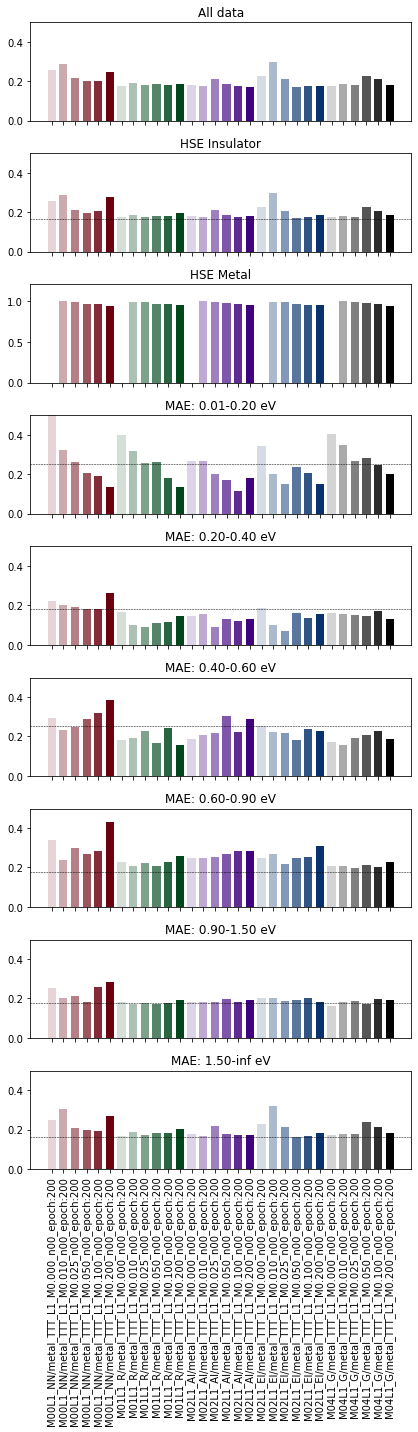

In [99]:
root_models = 'c:/WORKSPACE_KRICT/MODELS/202204/nmre'
#_ = plot_acc_of_model(model_types=['M01R','M02_AI','M02_EI'], model_names=['L1log_'])
#_ = plot_acc_by_model(model_types=['M01R','M02_AI','M02_EI','M02Mix_AI','M02Mix_EI'], model_names=["*"], figsize=(25,30))
#_ = plot_acc_by_model(model_types=['M01R','M02_EI','M02Mix_EI'], model_names=["*"], figsize=(25,30))
#_ = plot_acc_by_model(model_types=['M02Mix_AI','M02Mix_EI'], model_names=["*"], figsize=(20,30))
#_ = plot_acc_by_model(model_types=['M02_AI','M02_EI','M02Log_AI','M02Log_EI','M02Mix_AI','M02Mix_EI','M04L1'], model_names=['FTT'], figsize=(20,30), idxs=[-3])
_ = plot_acc_by_model(model_types=[
            'M00L1_NN','M01L1_R','M02L1_AI','M02L1_EI','M04L1_G',
            'M02Log_AI','M02Log_EI','M02Mix_AI','M02Mix_EI'
#            'M01L1_R','M02L1_EI','M02Log_EI','M02Mix_EI'
        ], 
        model_names=[
#                'TFF_L1_M0.010','TFF_L1_M0.025','TFF_L1_M0.05','TFF_L1_M0.1','TFF_L1_M0.2',
#                'FFF_L1_M0.000','FFF_L1_M0.010','FFF_L1_M0.025','FFF_L1_M0.05','FFF_L1_M0.1','FFF_L1_M0.2',
#                'FTT_L1_M0.000','FTT_L1_M0.010','FTT_L1_M0.025','FTT_L1_M0.05','FTT_L1_M0.1','FTT_L1_M0.2',
#                'TFF_L1_M0.000','TFF_L1_M0.010','TFF_L1_M0.025','TFF_L1_M0.05','TFF_L1_M0.1','TFF_L1_M0.2',
                'TTT_L1_M0.000','TTT_L1_M0.010','TTT_L1_M0.025','TTT_L1_M0.05','TTT_L1_M0.1','TTT_L1_M0.2',
        ], figsize=(6,20), idxs=[0], subidx=-2, ylim=[0,0.5],
        value=False, 
        hbars=[(1,0.165),(3,0.254),(4,0.183),(5,0.251),(6,0.177),(7,0.178),(8,0.160)]
        )

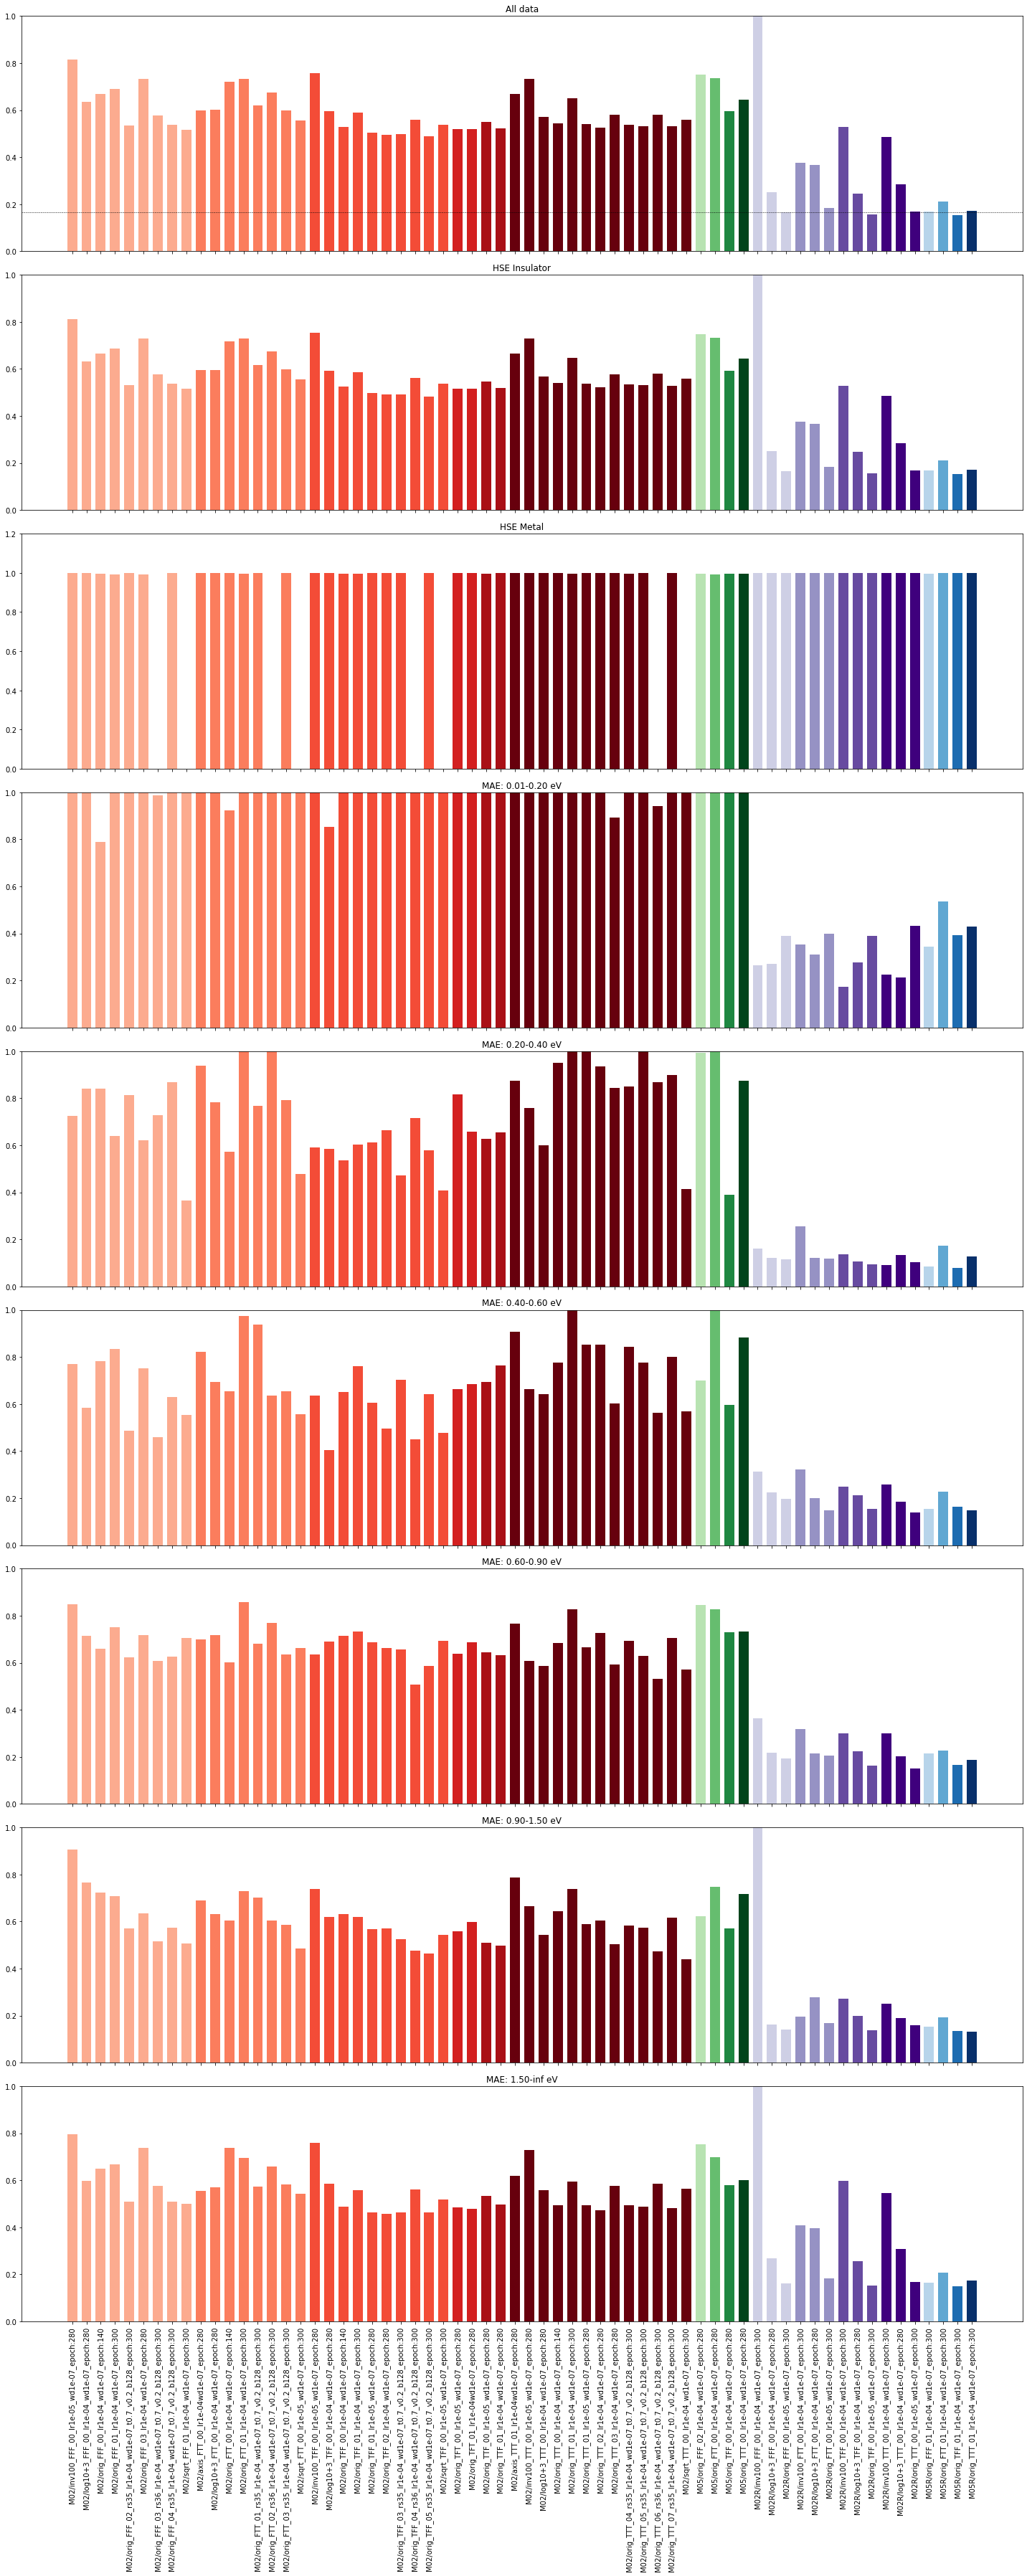

In [102]:
root_models = 'c:/WORKSPACE_KRICT/MODELS/202204/nmo'
_ = plot_acc_by_model(model_types=[
                        'M02','M05','M02R','M05R'
                      ], 
                      model_names=['*'], figsize=(20,50), idxs=[1], subidx=None, ylim=[0,1], 
                      value=False, hbars=[(0,0.165)])

In [31]:
root_models = 'C:/WORKSPACE_KRICT/MODELS/202204/nmre'
ids = get_prediction('M02_AI')['M02_AI/metal_FFF_00_L1_M0.0'][0][1][0].astype(int)

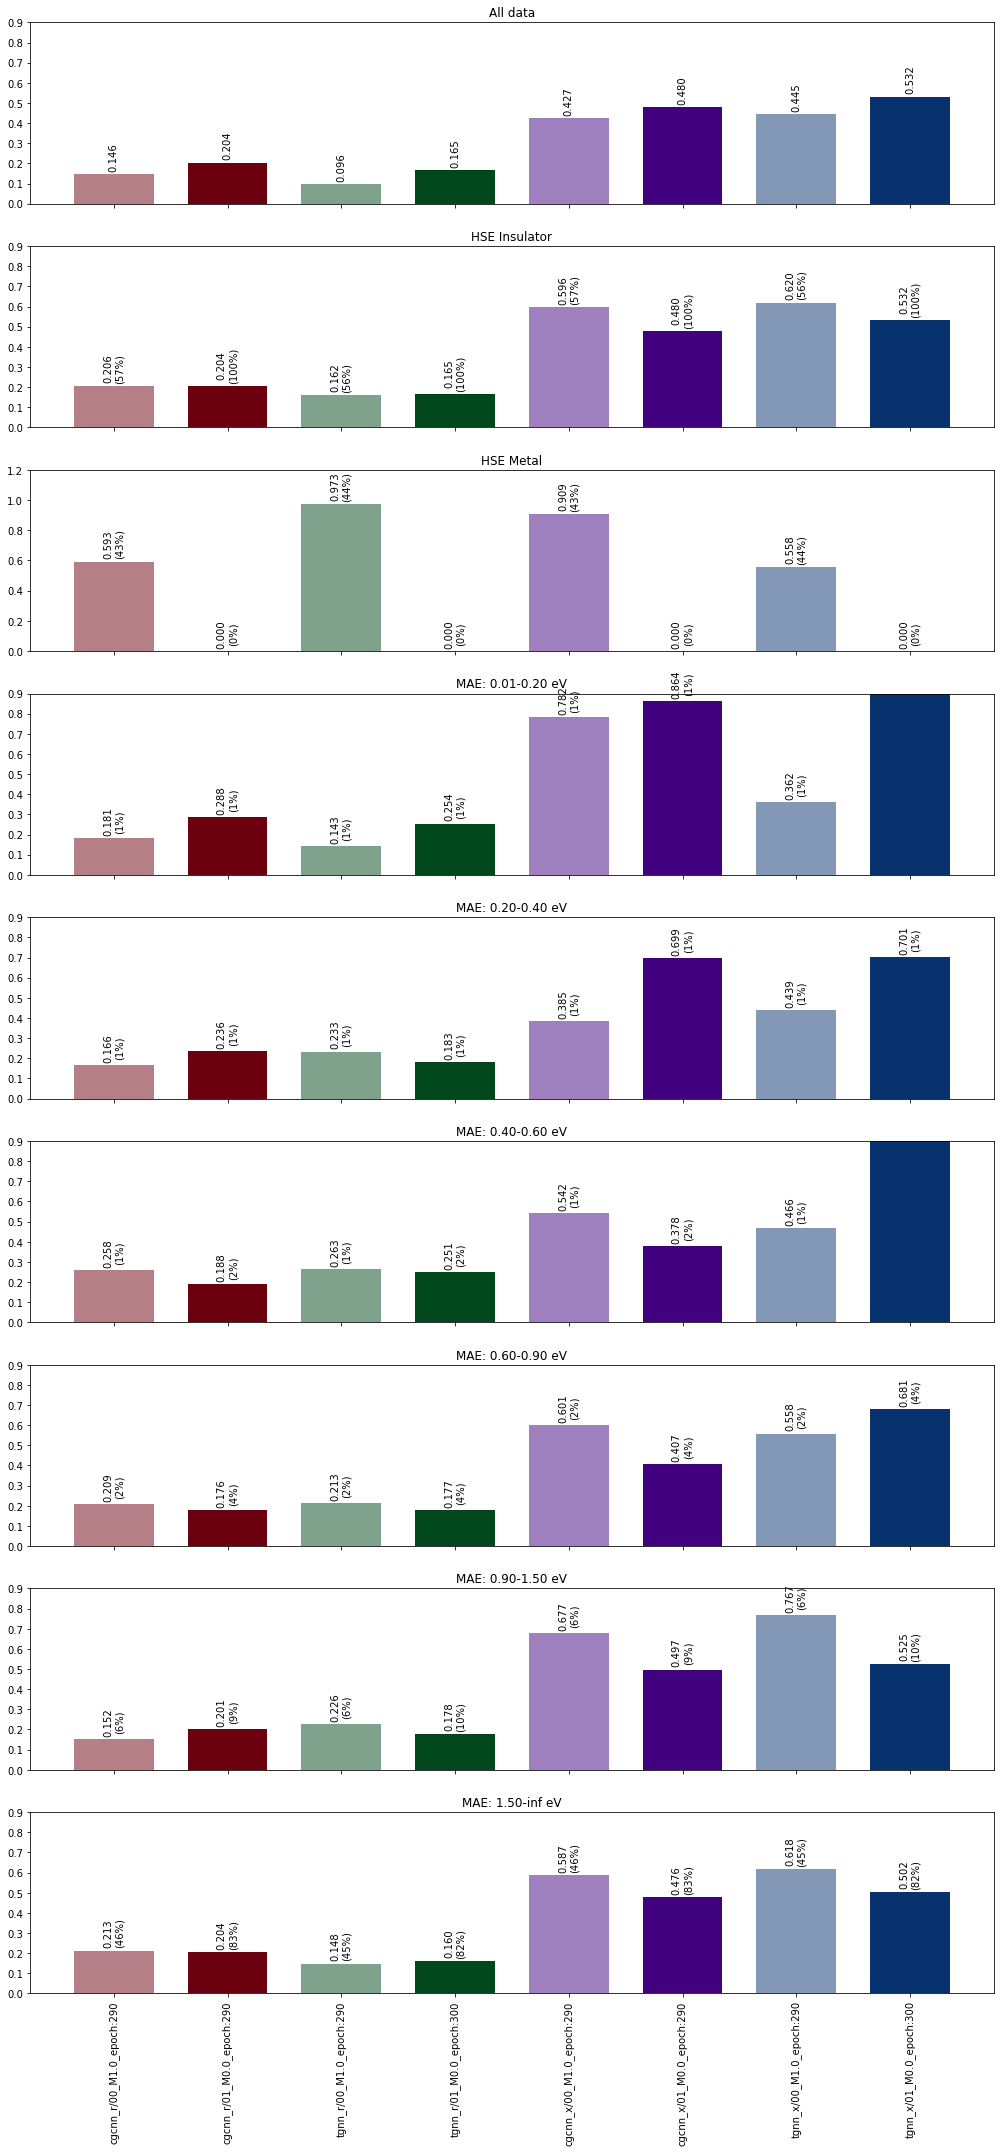

In [91]:
root_models = 'C:/WORKSPACE_KRICT/MODELS/202204/'

#_ = plot_data_by_model(model_types='M02_AI')
#_ = plot_data_by_model(model_types='M03R')
#_ = plot_acc_by_model(model_types=['M02_AI','M02_EI'], value=True)

#_ = plot_data_by_model(model_type='M02R')
#_ = plot_data_by_model(model_type='M03R')
root_models = 'C:/WORKSPACE_KRICT/MODELS/202204/baseline'
_ = plot_acc_by_model(model_types=['cgcnn_r','tgnn_r','cgcnn_x','tgnn_x'], order=-1, value=True, idxs=[0], subidx=1, figsize=(14,30), ylim=[0,0.9])

In [3]:
root_models = 'C:/WORKSPACE_KRICT/MODELS/202204/nmo'
_ = plot_data_by_model(model_types=[
#        'M00L1_NN','M01L1_R','M02L1_AI','M02L1_EI','M04L1_G',
        'M02R',
    ], model_names=[
        'orig_TFF','log10+3_TFF','inv100_TFF','orig_TTT','log10+3_TTT','inv100_TTT',
    ], gmax=3.25, with_metal=False, highlight_gga=False, with_title=False, 
    with_acc=True, acc_mul=0.1, ncol=3, idxs=[-2], bfs=(8,6))

NameError: name 'plot_data_by_model' is not defined

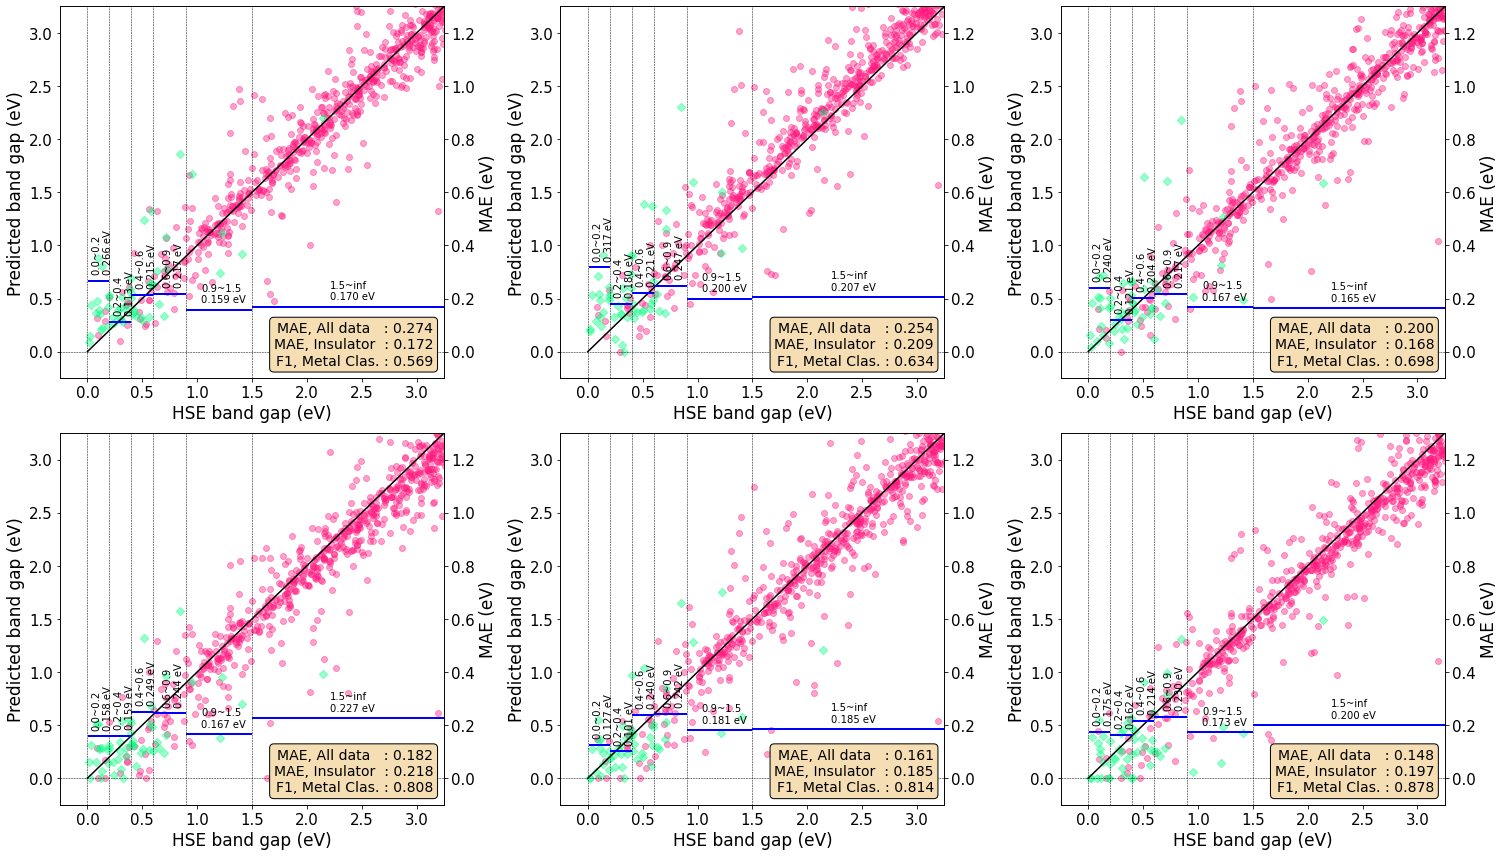

In [45]:
root_models = 'C:/WORKSPACE_KRICT/MODELS/202204/nmre'
_ = plot_data_by_model(model_types=[
#        'M00L1_NN',
#        'M01L1_R',
#        'M02L1_AI',
        'M02L1_EI',
#        'M02Log_AI',
#        'M02Log_EI',
#        'M02Mix_AI',
#        'M02Mix_EI',
#        'M04L1_G',
#        'M02L1_EI',
    ], model_names=[
#        'FFF_L1_M0.000', 'FFF_L1_M0.010', 'FFF_L1_M0.025', 'FFF_L1_M0.050','FFF_L1_M0.100', 'FFF_L1_M0.200',        
#        'FTT_L1_M0.000', 'FTT_L1_M0.010', 'FTT_L1_M0.025', 'FTT_L1_M0.050','FTT_L1_M0.100', 'FTT_L1_M0.200',
        'TFF_L1_M0.000', 'TFF_L1_M0.010', 'TFF_L1_M0.025', 'TFF_L1_M0.050','TFF_L1_M0.100', 'TFF_L1_M0.200',        
#        'TTT_L1_M0.000', 'TTT_L1_M0.010', 'TTT_L1_M0.025', 'TTT_L1_M0.050','TTT_L1_M0.100', 'TTT_L1_M0.200',
#        'FFF_L1log_M0.000', 'FFF_L1log_M0.010', 'FFF_L1log_M0.025', 'FFF_L1log_M0.050','FFF_L1log_M0.100', 'FFF_L1log_M0.200',
#        'FTT_L1log_M0.000', 'FTT_L1log_M0.010', 'FTT_L1log_M0.025', 'FTT_L1log_M0.050','FTT_L1log_M0.100', 'FTT_L1log_M0.200',
#        'TFF_L1log_M0.000', 'TFF_L1log_M0.010', 'TFF_L1log_M0.025', 'TFF_L1log_M0.050','TFF_L1log_M0.100', 'TFF_L1log_M0.200',
#        'TTT_L1log_M0.000', 'TTT_L1log_M0.010', 'TTT_L1log_M0.025', 'TTT_L1log_M0.050','TTT_L1log_M0.100', 'TTT_L1log_M0.200',
#        'FFF_L1+L1log_M0.000', 'FFF_L1+L1log_M0.010', 'FFF_L1+L1log_M0.025', 'FFF_L1+L1log_M0.050','FFF_L1+L1log_M0.100', 'FFF_L1+L1log_M0.200',
#        'FTT_L1+L1log_M0.000', 'FTT_L1+L1log_M0.010', 'FTT_L1+L1log_M0.025', 'FTT_L1+L1log_M0.050','FTT_L1+L1log_M0.100', 'FTT_L1+L1log_M0.200',
#        'TFF_L1+L1log_M0.000', 'TFF_L1+L1log_M0.010', 'TFF_L1+L1log_M0.025', 'TFF_L1+L1log_M0.050','TFF_L1+L1log_M0.100', 'TFF_L1+L1log_M0.200',
#        'TTT_L1+L1log_M0.000', 'TTT_L1+L1log_M0.010', 'TTT_L1+L1log_M0.025', 'TTT_L1+L1log_M0.050','TTT_L1+L1log_M0.100', 'TTT_L1+L1log_M0.200',
    ], gmax=3.25, with_metal=False, highlight_gga=True,  with_acc=True, with_title=False,
    acc_mul=0.1, ncol=3, idxs=[-2], bfs=(7,6))

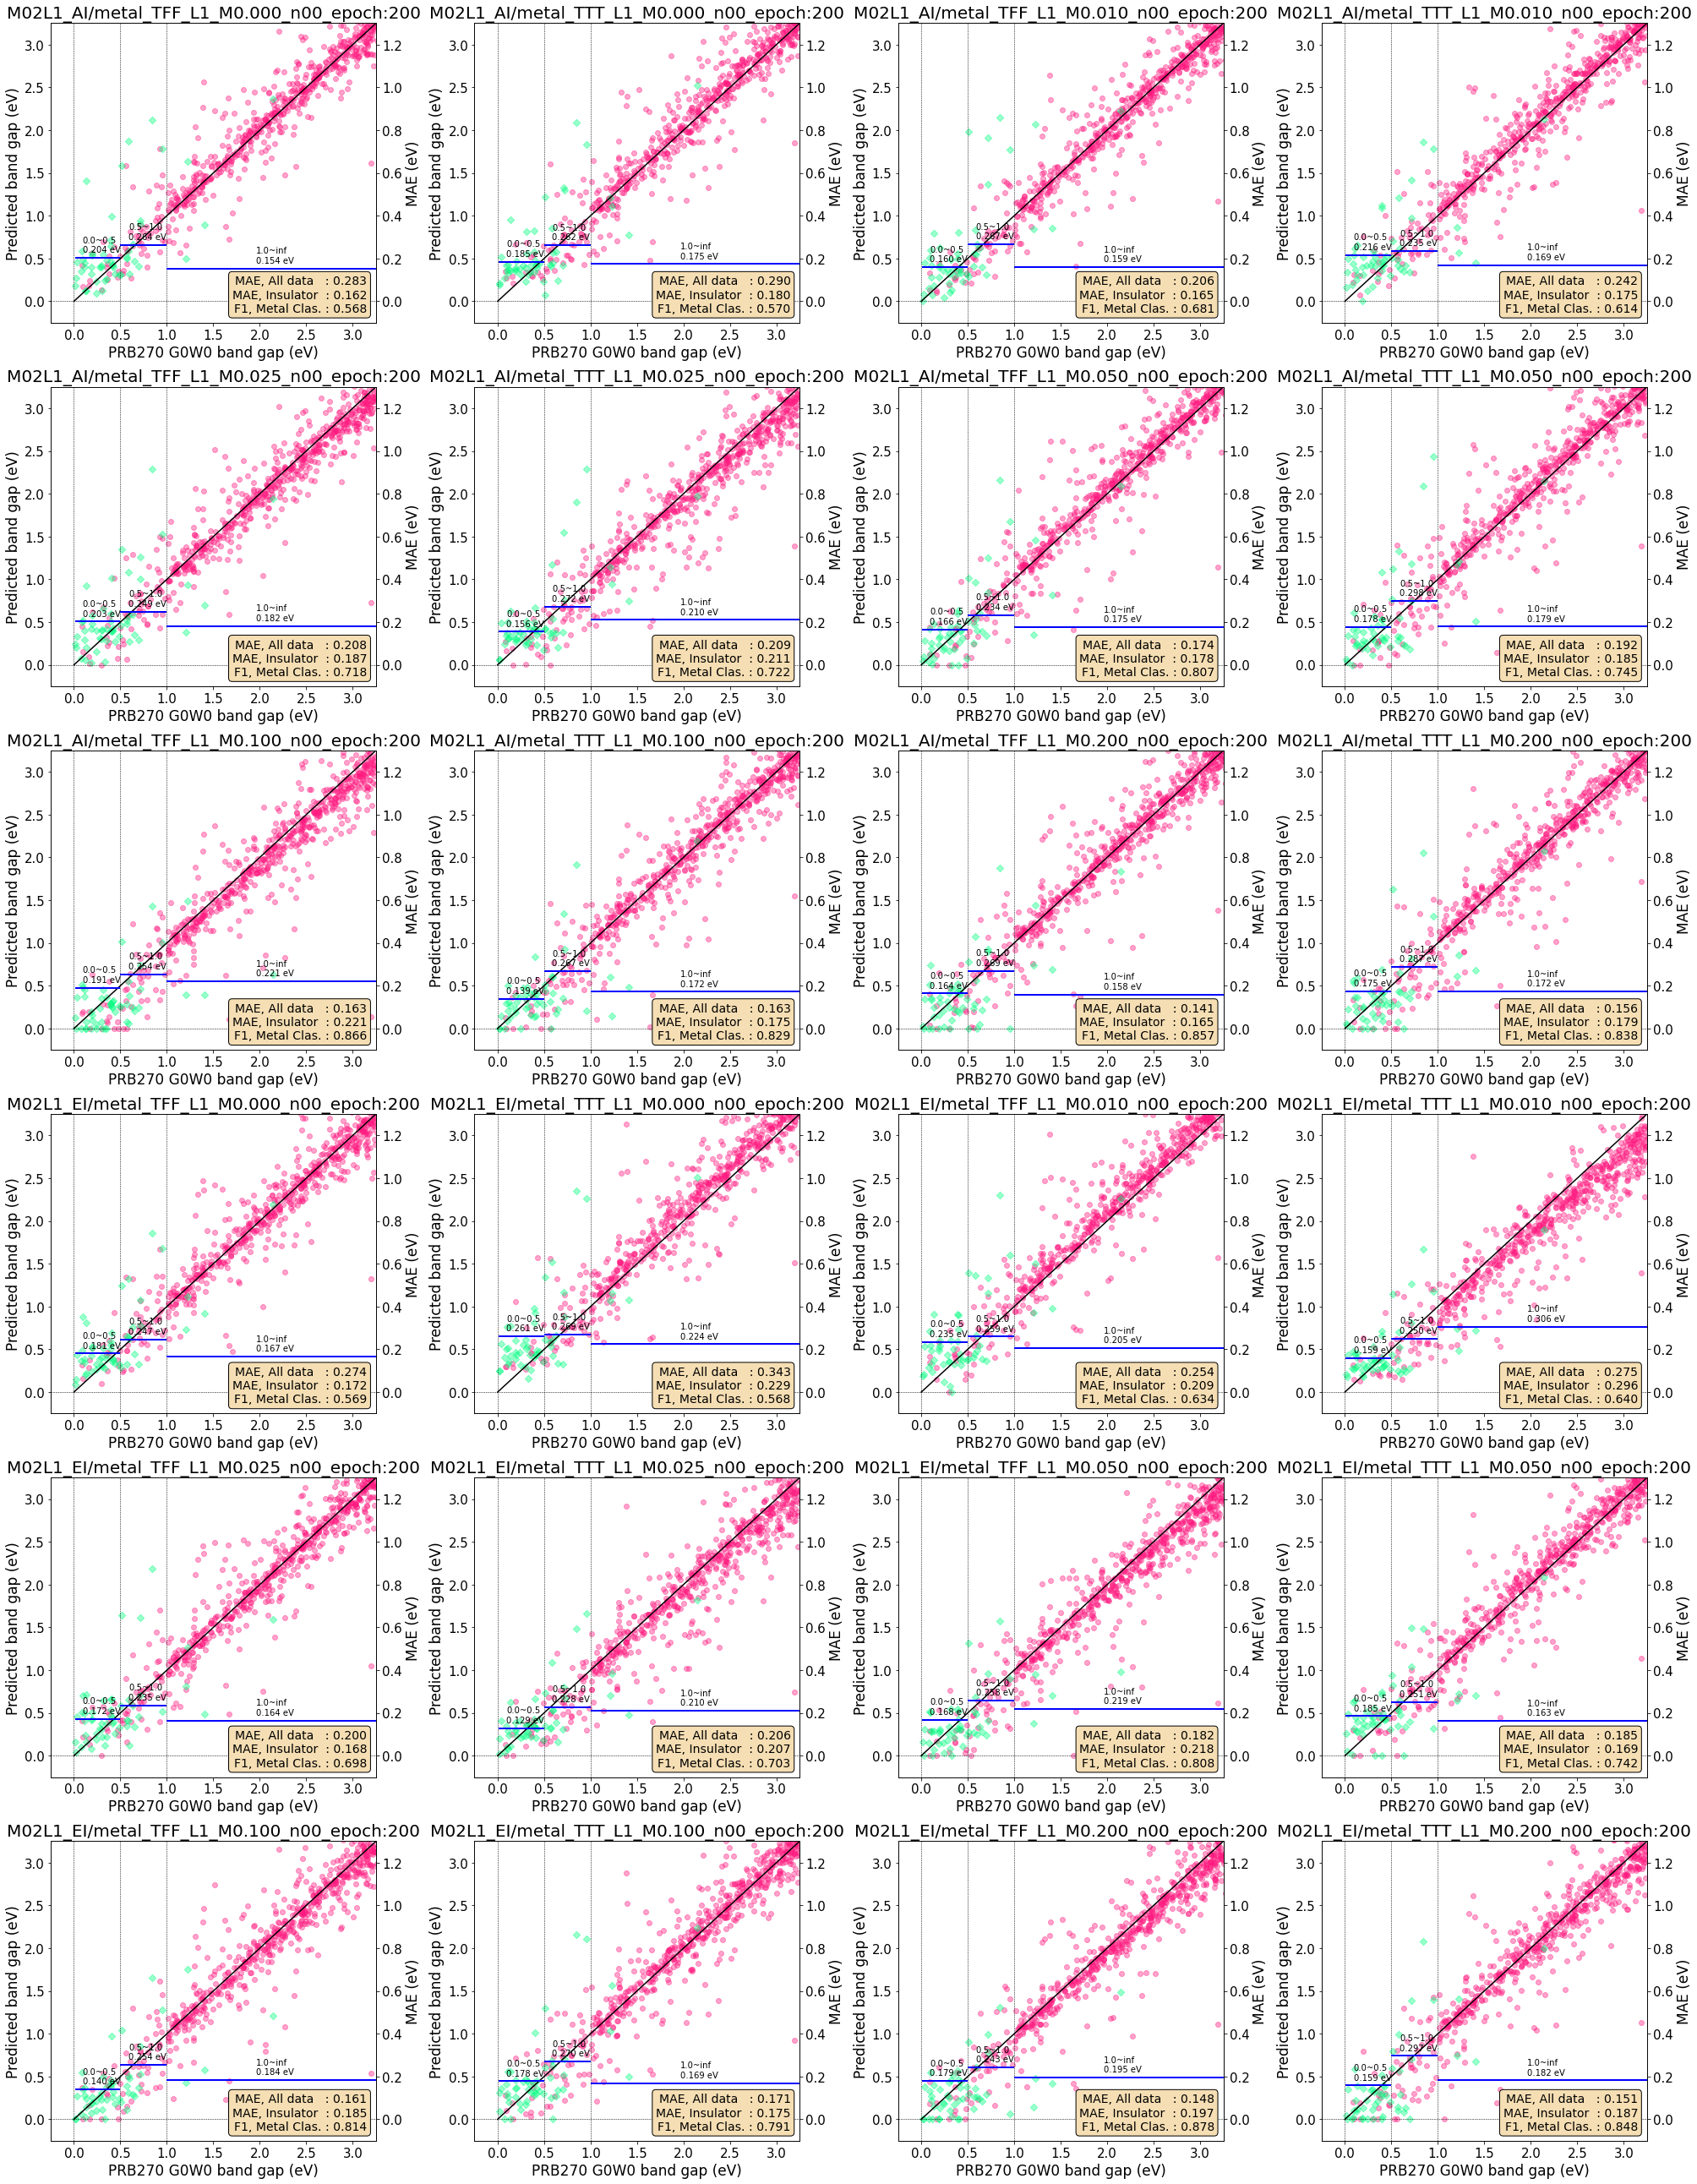

In [40]:
root_models = 'C:/WORKSPACE_KRICT/MODELS/202204/nmre'
_ = plot_data_by_model(model_types=[
#        'M00L1_NN',
#        'M01L1_R',
        'M02L1_AI',
        'M02L1_EI',
#        'M02Log_AI',
#        'M02Log_EI',
#        'M02Mix_AI',
#        'M02Mix_EI',
#        'M04L1_G',
#        'M02L1_EI',
    ], model_names=[
#        'FFF_L1_M0.000', 'FFF_L1_M0.010', 'FFF_L1_M0.025', 'FFF_L1_M0.050','FFF_L1_M0.100', 'FFF_L1_M0.200',        
#        'FTT_L1_M0.000', 'FTT_L1_M0.010', 'FTT_L1_M0.025', 'FTT_L1_M0.050','FTT_L1_M0.100', 'FTT_L1_M0.200',
        'TFF_L1_M0.000', 'TFF_L1_M0.010', 'TFF_L1_M0.025', 'TFF_L1_M0.050','TFF_L1_M0.100', 'TFF_L1_M0.200',        
        'TTT_L1_M0.000', 'TTT_L1_M0.010', 'TTT_L1_M0.025', 'TTT_L1_M0.050','TTT_L1_M0.100', 'TTT_L1_M0.200',
#        'FFF_L1log_M0.000', 'FFF_L1log_M0.010', 'FFF_L1log_M0.025', 'FFF_L1log_M0.050','FFF_L1log_M0.100', 'FFF_L1log_M0.200',
#        'FTT_L1log_M0.000', 'FTT_L1log_M0.010', 'FTT_L1log_M0.025', 'FTT_L1log_M0.050','FTT_L1log_M0.100', 'FTT_L1log_M0.200',
#        'TFF_L1log_M0.000', 'TFF_L1log_M0.010', 'TFF_L1log_M0.025', 'TFF_L1log_M0.050','TFF_L1log_M0.100', 'TFF_L1log_M0.200',
#        'TTT_L1log_M0.000', 'TTT_L1log_M0.010', 'TTT_L1log_M0.025', 'TTT_L1log_M0.050','TTT_L1log_M0.100', 'TTT_L1log_M0.200',
#        'FFF_L1+L1log_M0.000', 'FFF_L1+L1log_M0.010', 'FFF_L1+L1log_M0.025', 'FFF_L1+L1log_M0.050','FFF_L1+L1log_M0.100', 'FFF_L1+L1log_M0.200',
#        'FTT_L1+L1log_M0.000', 'FTT_L1+L1log_M0.010', 'FTT_L1+L1log_M0.025', 'FTT_L1+L1log_M0.050','FTT_L1+L1log_M0.100', 'FTT_L1+L1log_M0.200',
#        'TFF_L1+L1log_M0.000', 'TFF_L1+L1log_M0.010', 'TFF_L1+L1log_M0.025', 'TFF_L1+L1log_M0.050','TFF_L1+L1log_M0.100', 'TFF_L1+L1log_M0.200',
#        'TTT_L1+L1log_M0.000', 'TTT_L1+L1log_M0.010', 'TTT_L1+L1log_M0.025', 'TTT_L1+L1log_M0.050','TTT_L1+L1log_M0.100', 'TTT_L1+L1log_M0.200',
    ], gmax=3.25, with_metal=False, highlight_gga=True,  with_acc=True, with_title=True,
    acc_mul=0.1, ncol=4, idxs=[-2], bfs=(7,6))

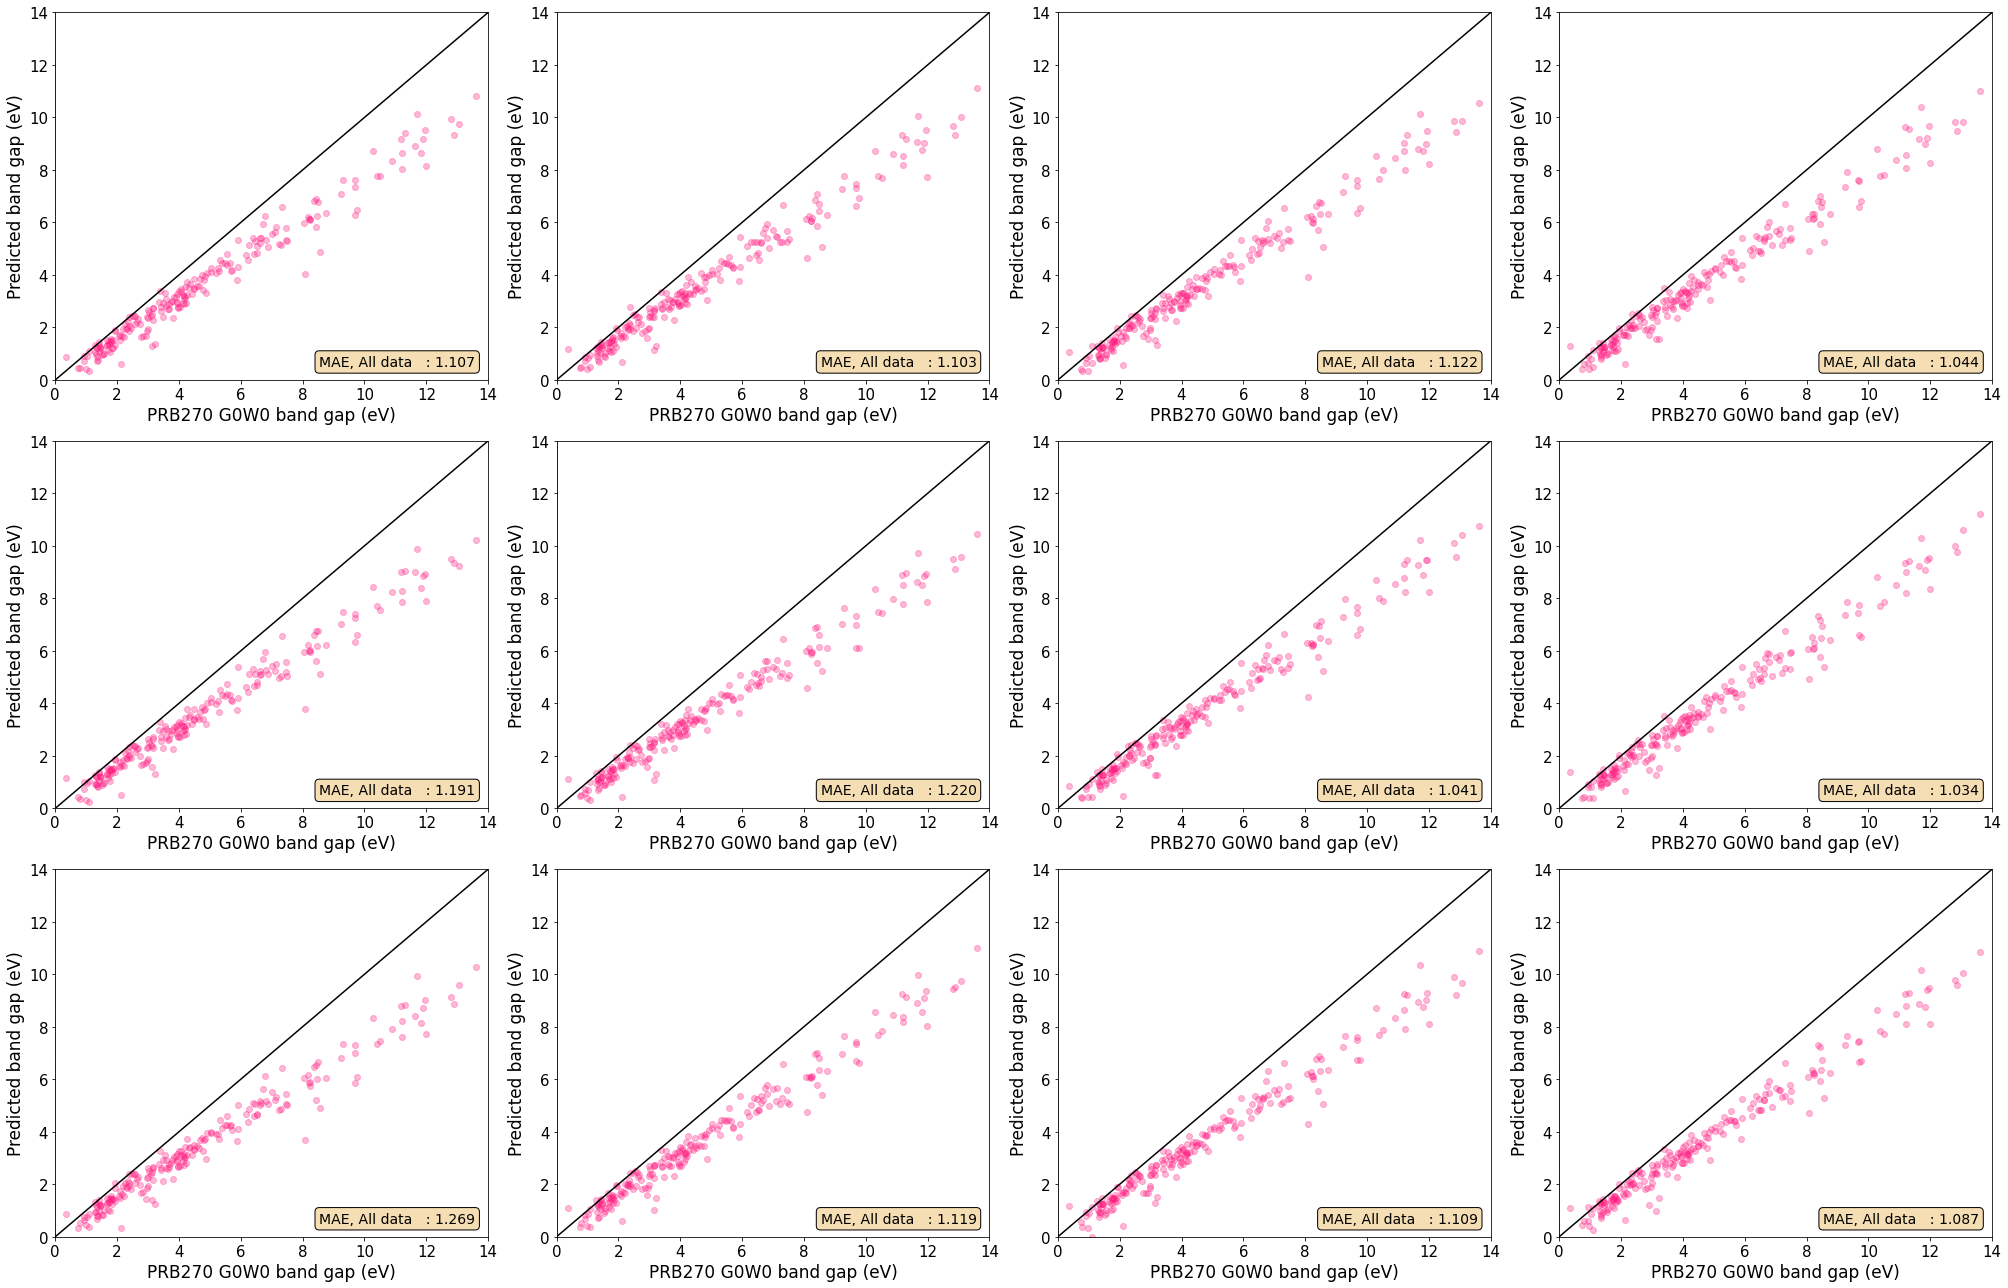

In [5]:
root_models = 'C:/WORKSPACE_KRICT/MODELS/202204/nmre'
_ = plot_data_by_model(model_types=[
#        'M00L1_NN',
#        'M01L1_R',
        'M02L1_AI',
#        'M02L1_EI',
    ], model_names=[
        'TFF_L1_M0.000', 'TFF_L1_M0.010', 'TFF_L1_M0.025', 'TFF_L1_M0.050','TFF_L1_M0.100', 'TFF_L1_M0.200',        
        'TTT_L1_M0.000', 'TTT_L1_M0.010', 'TTT_L1_M0.025', 'TTT_L1_M0.050','TTT_L1_M0.100', 'TTT_L1_M0.200',
    ], gmax=14, with_metal=False, highlight_gga=False,  with_acc=False, with_title=False,
    acc_mul=0.1, ncol=4, idxs=[-2], bfs=(7,6))

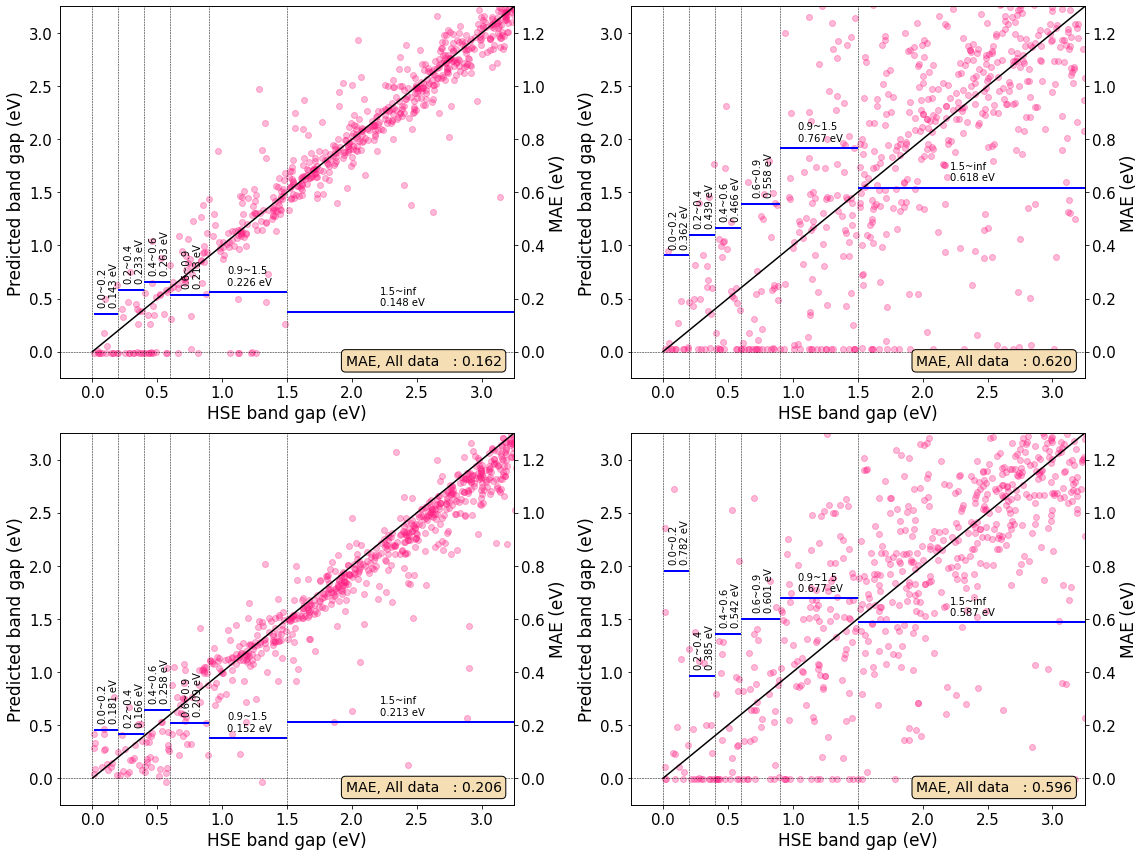

In [90]:
root_models = 'C:/WORKSPACE_KRICT/MODELS/202204/baseline'
_ = plot_data_by_model(model_types=['tgnn_r','tgnn_x','cgcnn_r','cgcnn_x',], 
            model_names=['M1.0'], gmax=3.25, with_metal=False, highlight_gga=False, 
            with_title=False, with_acc=True, acc_mul=0.1, ncol=2, idxs=[-2], bfs=(8,6))

In [105]:
dfp = pd.read_csv('C:/WORKSPACE_KRICT/MODELS/202204/baseline/cgcnn_r/00_M1.0/test.00280.csv')
dfo = pd.read_csv('C:/WORKSPACE_KRICT/DATA/data_snu/with_metal/id_target.test.baseline.csv')
np.sum((dfp.target < 1e-2) & (dfp.prediction < 1e-2))
np.sum(dfp.prediction < 1e-1)

1531

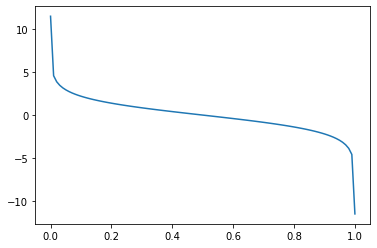

In [41]:
x = np.linspace(1e-5, 1-1e-5, 100)
y = np.log((1-x)/x)
plt.plot(x,y)

In [1]:
#pred = get_prediction(model_type='M02Log_AI')
_d = plot_graph({'xx':pred['M02Log_AI/metal_FFF_L1log_M0.000_n00'][-1][-1]})

NameError: name 'plot_graph' is not defined

In [1]:
root_models = 'C:/WORKSPACE_KRICT/MODELS/202204/nmre'
_ = plot_data_by_model(model_types=['M02Log_AI'], model_names=['TFF'], gmax=2.25, highlight_gga=True, 
                       with_acc=True, bfs=(9, 7), ncol=2, subidx=-2)

NameError: name 'plot_data_by_model' is not defined

In [ ]:
get_prediction(model_type='M00_NN')

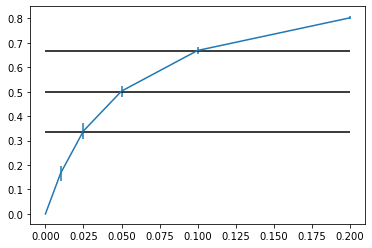

In [82]:
def calc_frac(ratio):
    global df
    subset = (df.gap_hse != 0) | (np.array(df.gap_hse == 0, dtype=int)*np.random.rand(df.shape[0]) < ratio)

    hse_metal = (df.gap_hse == 0) & subset
    gga_metal = (df.gap_gga == 0) & subset
    both_metal = hse_metal & gga_metal 
    return np.sum(both_metal)/np.sum(gga_metal)
    
x = []
y = []
e = []
#for ratio in np.linspace(0, 0.2, 50):
for ratio in [0, 0.01, 0.025, 0.05, 0.1, 0.2]:
    x.append(ratio)
    val = []
    for n in range(50):
        val.append(calc_frac(ratio))
    y.append(np.mean(val))
    e.append(np.std(val)*2)

y = np.array(y)
e = np.array(e)
plt.errorbar(x,y,yerr=e)
plt.hlines([1/3,1/2,2/3], xmin=0, xmax=0.2, colors='k')


In [83]:
y

array([0.        , 0.16651377, 0.33930753, 0.50221275, 0.66844865,
       0.80185334])

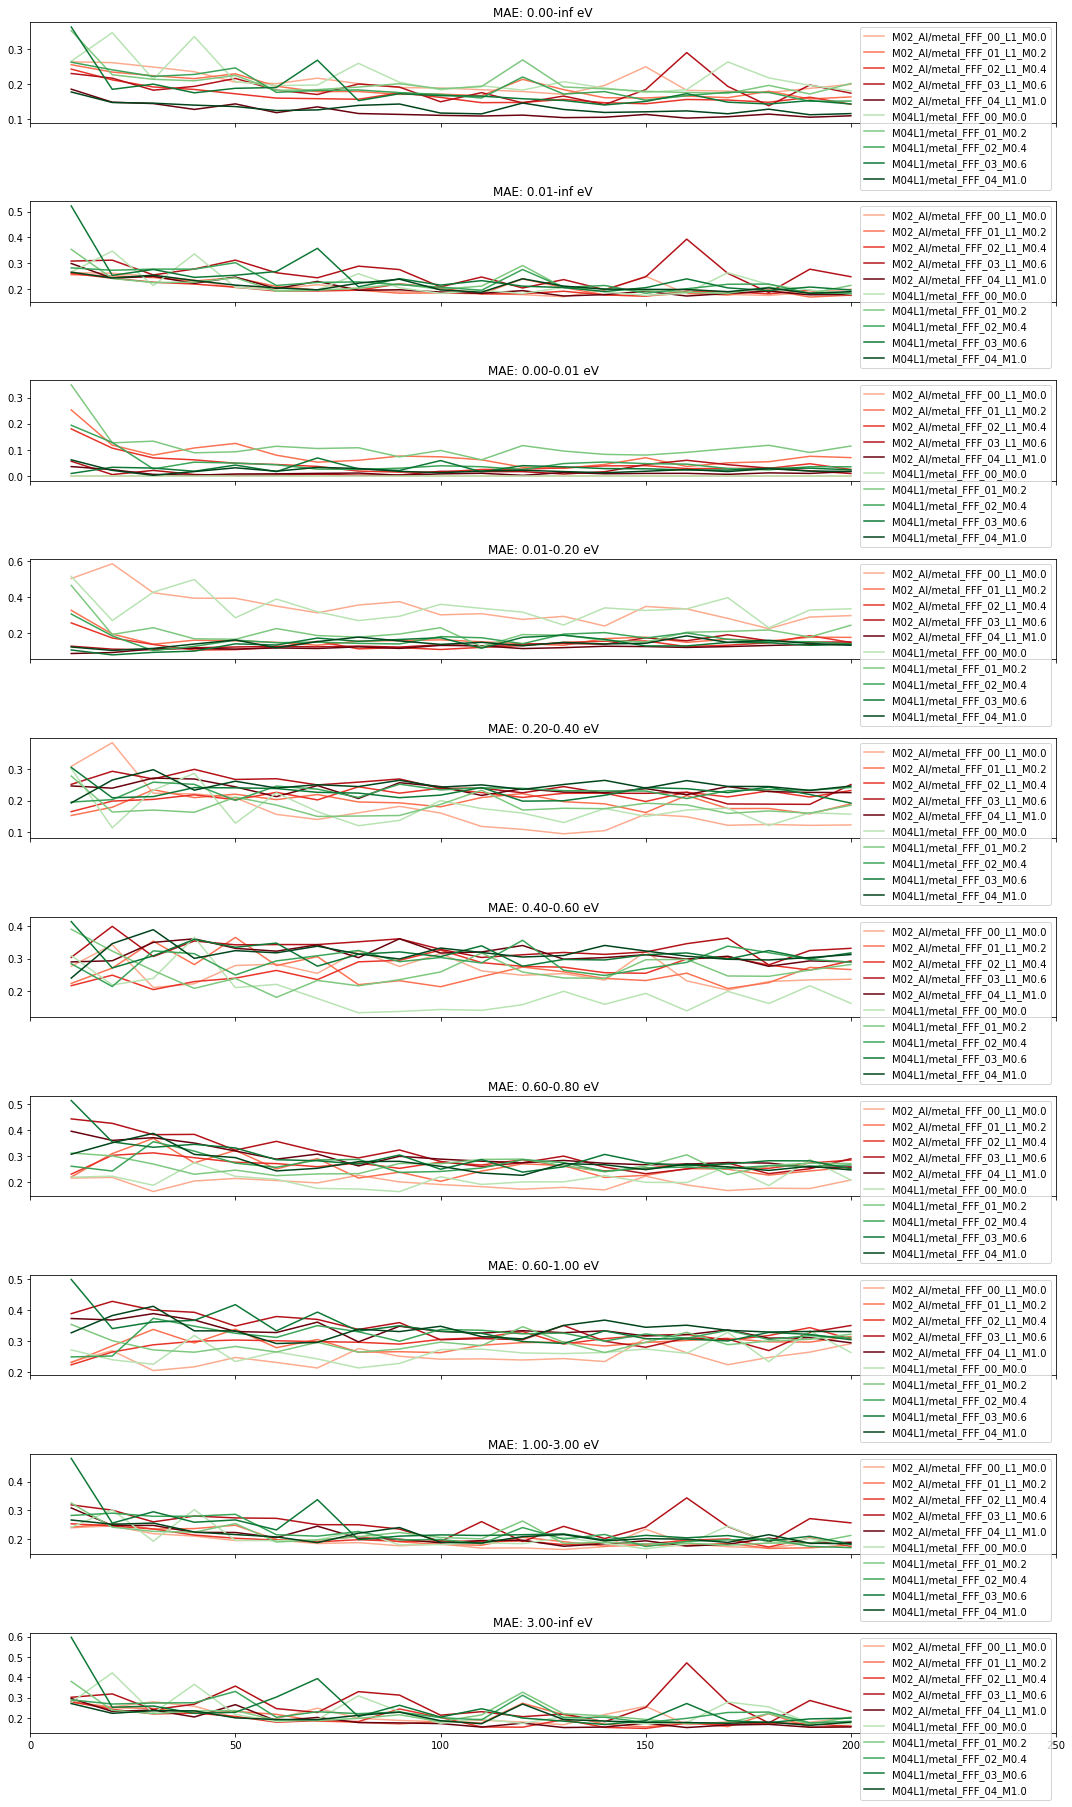

In [138]:
root_models = 'D:/MODELS/202204/nmre'
#_ = plot_data_of_model(model_type='M02R', model_name='FFF_01')
#_ = plot_acc_of_model(model_types=['M02_EI'], model_names='TFF_')
_ = plot_acc_of_model(model_types=['M02_AI','M04L1'], model_names='FFF', idxs=[-1], subidx=None, figsize=(15, 25), xlim=[0,250])

In [324]:
root_models = 'C:/WORKSPACE_KRICT/MODELS/202204/nmre'
ndim = 720000
hse_mask = np.zeros((ndim), dtype=bool)
hse_mask[np.array(df[df.gap_hse != 0].icsd_number)] = True
gga_mask = np.zeros((ndim), dtype=bool)
gga_mask[np.array(df[df.gap_gga != 0].icsd_number)] = True
all_mask = np.zeros((ndim), dtype=bool)
all_mask[np.array(df.icsd_number)] = True

def transpose_dict(mat1):
    mat2 = {}
    for k1, d1 in mat1.items():
        for k2, d2 in d1.items():
            if k2 not in mat2.keys(): mat2[k2] = {}
            mat2[k2][k1] = d2
    return mat2

def get_id_mat(model_type, print_info=True):
    global hse_mask
    pred = get_prediction(model_type=model_type)
    idmat = {'FFF':{}, 'FTT':{}, 'TFF':{}, 'TTT':{}}
    for mtype, dat in pred.items():
        idxs = dat[0][1][0].astype(int)
        id = np.zeros((720000), dtype=bool)
        id[idxs] = True
        for k1 in idmat.keys():
            if k1 not in mtype: continue
            k2 = '{:.3f}'.format(float(mtype.split('_')[-1].replace('M','')))
            idmat[k1][k2] = id
    idmat = {
        k1:{k2:d2 for k2,d2 in sorted(d1.items(), key=lambda x: x[0])
            } for k1,d1 in idmat.items()
    }
    if print_info: print_mat_info(idmat)
    return idmat

def print_mat_info(idmat):
    global hse_mask
    for scale, d1 in idmat.items():
        if len(d1) < 2: continue
        mrate = np.array(list(d1.keys()))
        idxs  = np.vstack(list(d1.values()))
        print(f'{scale} ----------------')
        for i in range(1, len(mrate)):
            r1 = mrate[i-1]
            r2 = mrate[i]
            m1 = idxs[i-1] 
            m2 = idxs[i] 
            m3 = m1 & m2
            m1i = m1 & hse_mask
            m2i = m2 & hse_mask
            m3i = m3 & hse_mask
            m1m = m1 & ~hse_mask
            m2m = m2 & ~hse_mask
            m3m = m3 & ~hse_mask
            if np.sum(m3) != np.sum(m1) or np.sum(m3) != np.sum(m1):
                print('All data - {}: {}  /  {}: {}  /  dup: {}'.format(r1, np.sum(m1), r2, np.sum(m2), np.sum(m3)))
            if np.sum(m3i) != np.sum(m1i) or np.sum(m3i) != np.sum(m1i):
                print('Ins data - {}: {}  /  {}: {}  /  dup: {}'.format(r1, np.sum(m1i), r2, np.sum(m2i), np.sum(m3i)))
#            if np.sum(m3m) != np.sum(m1m) or np.sum(m3m) != np.sum(m1m):
                print('Met data - {}: {}  /  {}: {}  /  dup: {}'.format(r1, np.sum(m1m), r2, np.sum(m2m), np.sum(m3m)))

    print('*'*50)
    print('transposed')
    print('*'*50)
    idmat_T = transpose_dict(idmat)
    for mrate, d1 in idmat_T.items():
        scale = np.array(list(d1.keys()))
        idxs  = np.vstack(list(d1.values()))
        print(f'{mrate} ----------------')
        for i in range(1, len(scale)):
            r1 = scale[i-1]
            r2 = scale[i]
            m1 = idxs[i-1] 
            m2 = idxs[i] 
            m3 = m1 & m2
            m1i = m1 & hse_mask
            m2i = m2 & hse_mask
            m3i = m3 & hse_mask
            m1m = m1 & ~hse_mask
            m2m = m2 & ~hse_mask
            m3m = m3 & ~hse_mask
            if np.sum(m3) != np.sum(m1) or np.sum(m3) != np.sum(m1):
                print('All data - {}: {}  /  {}: {}  /  dup: {}'.format(r1, np.sum(m1), r2, np.sum(m2), np.sum(m3)))
            if np.sum(m3i) != np.sum(m1i) or np.sum(m3i) != np.sum(m1i):
                print('Ins data - {}: {}  /  {}: {}  /  dup: {}'.format(r1, np.sum(m1i), r2, np.sum(m2i), np.sum(m3i)))
#            if np.sum(m3m) != np.sum(m1m) or np.sum(m3m) != np.sum(m1m):
                print('Met data - {}: {}  /  {}: {}  /  dup: {}'.format(r1, np.sum(m1m), r2, np.sum(m2m), np.sum(m3m)))

def check_btw_model(mat1, mat2):
    global hse_mask
    print('{:10s} {:5s} / {:5s} / {:5s}'.format(' ','M1','M2','dup'))
    for m1k1, m1d1 in mat1.items():
        if m1k1 not in mat2.keys(): continue
        m2d1 = mat2[m1k1]
        for m1k2, m1d2 in m1d1.items():
            if m1k2 not in m2d1.keys(): continue
            m2d2 = m2d1[m1k2]
            print(f'{m1k1}/{m1k2} -----------------------------')
            m1d2i = m1d2 & hse_mask
            m2d2i = m2d2 & hse_mask
            m1d2m = m1d2 & ~hse_mask
            m2d2m = m2d2 & ~hse_mask
            dup  = m1d2 & m2d2
            dupi = dup & hse_mask
            dupm = dup & ~hse_mask
            if np.sum(dup) != np.sum(m1d2) or np.sum(dup) != np.sum(m2d2):
                print('All data - {:5d} / {:5d} / {:5d}'.format(np.sum(m1d2), np.sum(m2d2), np.sum(dup)))
            if np.sum(dupi) != np.sum(m1d2i) or np.sum(dupi) != np.sum(m2d2i):
                print('Ins data - {:5d} / {:5d} / {:5d}'.format(np.sum(m1d2i), np.sum(m2d2i), np.sum(dupi)))
            #if np.sum(dupm) != np.sum(m1d2m) or np.sum(dupm) != np.sum(m2d2m):
            print('Met data - {:5d} / {:5d} / {:5d}'.format(np.sum(m1d2m), np.sum(m2d2m), np.sum(dupm)))

def calc_metal_frac(mask):
    global hse_mask, gga_mask
    hse_metal = ~hse_mask & mask
    gga_metal = ~gga_mask & mask
    both_metal = hse_metal & gga_metal
    if np.sum(both_metal) == 0:
        return np.sum(gga_metal)
    return np.sum(both_metal)/np.sum(gga_metal)
    
        

In [163]:
m1 = get_id_mat('M00_NN', print_info=True)
m2 = get_id_mat('M01_R',  print_info=True)
#m3 = get_id_mat('M02_AI', print_info=False)
#m4 = get_id_mat('M02_EI', print_info=False)
#m5 = get_id_mat('M02Log_AI', print_info=False)
#m5 = get_id_mat('M02Log_EI', print_info=False)
#m5 = get_id_mat('M02Mix_AI', print_info=False)
#m5 = get_id_mat('M02Mix_EI', print_info=False)
#m5 = get_id_mat('M04L1_G', print_info=False)
check_btw_model(m1, m2)
#print_mat_info(m3)
#inss = m1['FFF']['0.010'] & hse_mask



FFF ----------------
All data - 0.000: 1040  /  0.010: 1049  /  dup: 1039
Ins data - 0.000: 1040  /  0.010: 1039  /  dup: 1039
Met data - 0.000: 0  /  0.010: 10  /  dup: 0
All data - 0.025: 1061  /  0.050: 1083  /  dup: 1060
Ins data - 0.025: 1040  /  0.050: 1039  /  dup: 1039
Met data - 0.025: 21  /  0.050: 44  /  dup: 21
FTT ----------------
All data - 0.000: 1040  /  0.010: 1049  /  dup: 1039
Ins data - 0.000: 1040  /  0.010: 1039  /  dup: 1039
Met data - 0.000: 0  /  0.010: 10  /  dup: 0
All data - 0.025: 1061  /  0.050: 1083  /  dup: 1060
Ins data - 0.025: 1040  /  0.050: 1039  /  dup: 1039
Met data - 0.025: 21  /  0.050: 44  /  dup: 21
**************************************************
transposed
**************************************************
0.000 ----------------
0.010 ----------------
0.025 ----------------
0.050 ----------------
0.100 ----------------
0.200 ----------------
FFF ----------------
All data - 0.000: 1040  /  0.010: 1049  /  dup: 1039
Ins data - 0.000: 1040  /

In [110]:
for scale, d in m4.items():
    for mr, mask in d.items():
        print(scale, mr, calc_metal_frac(mask))

FFF 0.000 52
FFF 0.010 0.16129032258064516
FFF 0.025 0.2876712328767123
FFF 0.050 0.4583333333333333
FFF 0.100 0.6030534351145038
FFF 0.200 0.7389162561576355
FFF 0.400 0.8498583569405099
FFF 0.600 0.8992395437262357
FFF 1.000 0.937793427230047
FTT 0.000 52
FTT 0.010 0.16129032258064516
FTT 0.025 0.2876712328767123
FTT 0.050 0.4583333333333333
FTT 0.100 0.6030534351145038
FTT 0.200 0.7389162561576355
FTT 0.400 0.8498583569405099
FTT 0.600 0.8992395437262357
FTT 1.000 0.937793427230047
TFF 0.000 52
TFF 0.200 0.7389162561576355
TFF 0.400 0.8498583569405099
TFF 0.600 0.8992395437262357
TFF 1.000 0.937793427230047
TTT 0.000 52
TTT 0.200 0.7389162561576355
TTT 0.400 0.8498583569405099
TTT 0.600 0.8992395437262357
TTT 1.000 0.937793427230047


In [326]:
masks = {}
for mr in [0.0, 0.01, 0.025, 0.05, 0.1, 0.2, 0.4, 0.6, 1]:
    key = '{:.3f}'.format(mr)
    with open(f'C:/WORKSPACE_KRICT/MODELS/202204/nmre/ids_m{key}.json') as f:
        d = json.load(f)
    for k,v in d.items():
        m = np.zeros((ndim), dtype=bool)
        m[np.array(v)] = True
        d[k] = m
    masks[key] = d

In [330]:
trains = np.zeros((ndim), dtype=bool)
valids = np.zeros((ndim), dtype=bool)
for mr, maskset in masks.items():
    trains = trains | maskset['train_ids'] 
    valids = valids | maskset['valid_ids']

In [338]:
idxs = np.arange(ndim)
ns = ~(trains | valids) & all_mask
ns_hse_ins = ns & hse_mask
ns_gga_ins = ns & gga_mask
ns_both_met = ns & ~hse_mask & ~gga_mask
ns_gga_met_hse_ins = ns & hse_mask & ~gga_mask
np.sum(ns), np.sum(ns_hse_ins), np.sum(ns_gga_ins), np.sum(ns_both_met), np.sum(ns_gga_met_hse_ins)

(1837, 1039, 987, 798, 52)

In [345]:
mask = np.zeros((df.shape[0]), dtype=bool)
for idx in idxs[ns]:
    mask = mask | (df.icsd_number == idx)
np.sum(mask)

1837

In [124]:
gga_zero_mask = np.zeros((720000), dtype=bool)
hse_zero_mask = np.zeros((720000), dtype=bool)
gga_zero = pd.read_csv('C:/WORKSPACE_KRICT/DATA/data_snu/gga_gap_zero/log.csv')
gga_zero_mask[np.array(gga_zero['icsd number'])] = True
hse_zero = pd.read_csv('C:/WORKSPACE_KRICT/DATA/data_snu/hse_gap_zero/log.csv')
hse_zero_mask[np.array(hse_zero['icsd number'])] = True

In [130]:
np.sum(gga_zero_mask) - 22, np.sum(hse_zero_mask) - 8, np.sum(gga_zero_mask & hse_zero_mask)

(6799, 1419, 3)

In [356]:
pts = []
for fn in os.listdir('C:/WORKSPACE_KRICT/MODELS/202204/nmre/M00_NN/metal_FFF_02_L1_M0.025'):
    if not fn.endswith('.pt'): continue
    pts.append(fn)
sorted(pts)

['model.00010.pt',
 'model.00020.pt',
 'model.00030.pt',
 'model.00040.pt',
 'model.00050.pt',
 'model.00060.pt',
 'model.00070.pt',
 'model.00080.pt',
 'model.00090.pt',
 'model.00100.pt',
 'model.00110.pt',
 'model.00120.pt',
 'model.00130.pt',
 'model.00140.pt',
 'model.00150.pt',
 'model.00160.pt',
 'model.00170.pt',
 'model.00180.pt',
 'model.00190.pt',
 'model.00200.pt']

In [131]:
import tgnn.util.crystal_conv as cc

train, val = cc.load_dataset('C:/WORKSPACE_KRICT/DATA/data_snu/with_metal', target_idx=3, ref_idx=1, fn='id_target.subset.csv', radius=4, model_type='tgnn', train_ratio=1, val_ratio=0)

100%|██████████| 9/9 [00:06<00:00,  1.42it/s]


tgnn_r 22906.950509548187
cgcnn_r 423.96209049224854


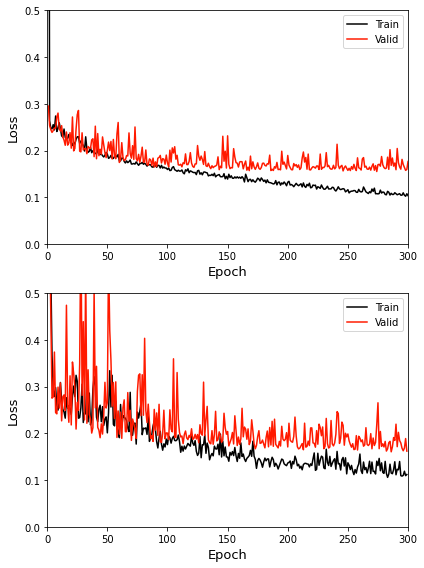

In [127]:
f, axs = plt.subplots(2,1,figsize=(6,8))
for i, model in enumerate(['tgnn_r','cgcnn_r']):
    train = pd.read_csv(f'C:/Users/KRICT/Downloads/run-{model}_01_M0.0-tag-train_loss.csv')
    valid = pd.read_csv(f'C:/Users/KRICT/Downloads/run-{model}_01_M0.0-tag-valid_loss.csv')
    t = train['Wall time'].values[-1] - train['Wall time'].values[0]
    print(model, t)
    axs[i].plot(train.Step, train.Value, c=[0,0,0], label='Train')
    axs[i].plot(valid.Step, valid.Value, c=[1,0.1,0], label='Valid')
    axs[i].set_xlim([0,300])
    axs[i].set_ylim([0,0.5])
    axs[i].set_xlabel('Epoch', fontsize=13)
    axs[i].set_ylabel('Loss', fontsize=13)
    axs[i].legend(loc='upper right')
plt.tight_layout()


423.96209049224854